<a href="https://colab.research.google.com/github/nana-hyun/AI_experience_lab/blob/main/ADNI_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier

import matplotlib as mpl

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import seaborn as sns

In [3]:
# Load the data
data = pd.read_csv("/content/drive/MyDrive/team-a/0-data/adni-fs.csv")

TA = data.filter(regex="TA$")

TA = TA.dropna(axis=1)
data_extracted = pd.merge(left=data[['diagnosis']], right=TA, left_index=True, right_index=True)
data_extracted = data_extracted.dropna()


# Prepare the data
data_ADCN = data_extracted[data_extracted['diagnosis'].isin(['CN','AD'])]

X = data_ADCN.filter(regex="TA$").values
y = data_ADCN['diagnosis'].values

In [4]:
# y CN = 0 / AD = 1
y[y == 'CN']= 0
y[y == 'AD'] = 1


y = y.astype(int)

# Training

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
# SGD_Classifier

sgd_clf_AD = SGDClassifier(random_state=42)
sgd_clf_AD.fit(X_train, y_train)


SGDClassifier(random_state=42)

In [7]:
# Logistic Regression

log_reg_AD = LogisticRegression(solver="lbfgs", max_iter=500, random_state=42)
log_reg_AD.fit(X_train, y_train)


LogisticRegression(max_iter=500, random_state=42)

In [8]:
# linear SVM

lin_svm_AD = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge",max_iter=30000, random_state=42)),
    ])

lin_svm_AD.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=1, loss='hinge', max_iter=30000,
                           random_state=42))])

In [9]:
# nonlinear SVM

poly_svm_AD = Pipeline([
        ("poly_features", PolynomialFeatures(degree=1)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=400000, random_state=42))
    ])

poly_svm_AD.fit(X_train, y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=10, loss='hinge', max_iter=400000,
                           random_state=42))])

In [10]:
# RandomForest

forest_clf_AD = RandomForestClassifier(random_state = 42)
forest_clf_AD.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Test

In [11]:
# K fold test

def K_fold(X,y,model_name,fold):
  cv_accuracy = []
  n_iter =0

  kfold = KFold(n_splits=fold)
  for train_index, test_index in kfold.split(X):  # X 데이터를 위에서 지정한 kfold 숫자로 분할
      # Train / Test split
      x_train, x_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      
      # Train model
      model_name.fit(x_train, y_train)

      # Test model
      pred = model_name.predict(x_test)
      n_iter += 1
      
      # Model evalutation: metric (acc, F1, Pre_recall, AUC)
      accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
      train_size = x_train.shape[0]
      test_size = x_test.shape[0]
      
      print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
            .format(n_iter, accuracy, train_size, test_size))
      print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
      cv_accuracy.append(accuracy)
      
  print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

In [12]:
# confusion matrix_model evaluation

def confusion_plt(X_test,y_test,model_name):
  pred_y = model_name.predict(X_test)
  cf_matrix=confusion_matrix(y_test, pred_y)

  group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [21]:
# Precision Recall, F1 score, roc

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)

def precision_recall_roc(X_test,y_test,model_name):
  pred_y = model_name.predict(X_test)
  
  if model_name == forest_clf_AD:
    y_scores = cross_val_predict(model_name, X_test, y_test, cv = 5, method = "predict_proba")[:,1]
  else:
    y_scores = cross_val_predict(model_name, X_test, y_test, cv = 5, method = "decision_function")
  
  fpr_AD, tpr_AD, thresholds_AD = roc_curve(y_test, y_scores)
  print("f1 score : {}".format(f1_score(y_test, pred_y)))
  print("precision score : {}".format(precision_score(y_test, pred_y)))
  print("recall score : {}".format(recall_score(y_test, pred_y)))
  print("roc auc score : {}".format(roc_auc_score(y_test, pred_y)))
  plot_roc_curve(fpr_AD, tpr_AD,model_name)


#1 교차 검증 정확도 : 0.8389,  학습 데이터 크기 : 592,  검증 데이터 크기 : 149
#1 검증 세트 인덱스 : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148]

#2 교차 검증 정확도 : 0.6689,  학습 데이터 크기 : 593,  검증 데이터 크기 : 148
#2 검증 세트 인덱스 : [149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 20

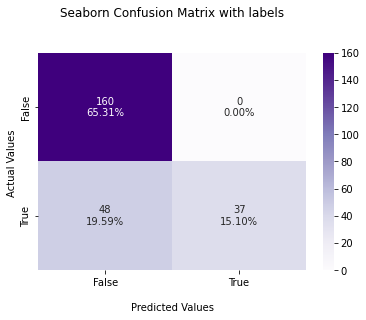

f1 score : 0.6065573770491803
precision score : 1.0
recall score : 0.43529411764705883
roc auc score : 0.7176470588235294


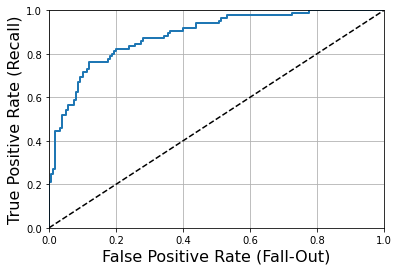

In [14]:
#@title SGD_Classifier test { vertical-output: true }
# SGD_Classifier test

K_fold(X,y,sgd_clf_AD,5)
confusion_plt(X_test, y_test, sgd_clf_AD)
precision_recall_roc(X_test,y_test,sgd_clf_AD)


#1 교차 검증 정확도 : 0.8859,  학습 데이터 크기 : 592,  검증 데이터 크기 : 149
#1 검증 세트 인덱스 : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148]

#2 교차 검증 정확도 : 0.8716,  학습 데이터 크기 : 593,  검증 데이터 크기 : 148
#2 검증 세트 인덱스 : [149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 20

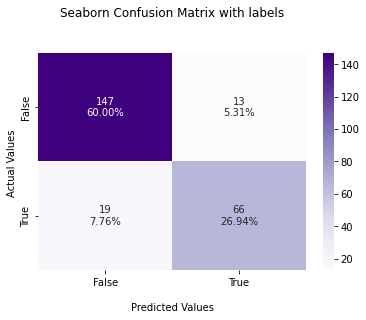

f1 score : 0.8048780487804879
precision score : 0.8354430379746836
recall score : 0.7764705882352941
roc auc score : 0.8476102941176469


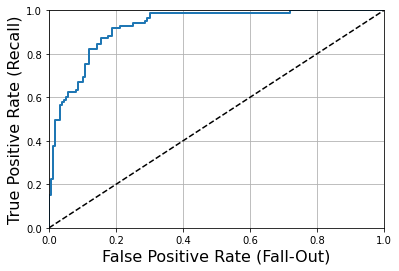

In [15]:
#@title Logistic regression test { vertical-output: true }
# Logistic regression test

K_fold(X,y,log_reg_AD,5)
confusion_plt(X_test, y_test, log_reg_AD)
precision_recall_roc(X_test, y_test, log_reg_AD)


#1 교차 검증 정확도 : 0.8389,  학습 데이터 크기 : 592,  검증 데이터 크기 : 149
#1 검증 세트 인덱스 : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148]

#2 교차 검증 정확도 : 0.8311,  학습 데이터 크기 : 593,  검증 데이터 크기 : 148
#2 검증 세트 인덱스 : [149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 20

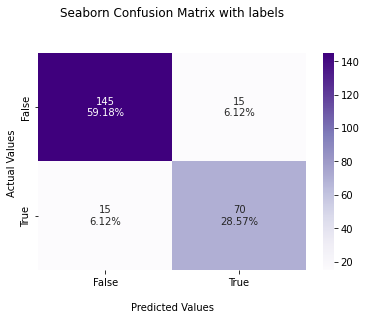

f1 score : 0.8235294117647058
precision score : 0.8235294117647058
recall score : 0.8235294117647058
roc auc score : 0.8648897058823529


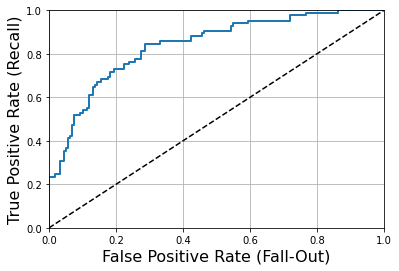

In [16]:
#@title Linear SVM test { vertical-output: true }
# linear SVM test

K_fold(X,y,lin_svm_AD,5)
confusion_plt(X_test, y_test, lin_svm_AD)
precision_recall_roc(X_test,y_test,lin_svm_AD)


#1 교차 검증 정확도 : 0.8255,  학습 데이터 크기 : 592,  검증 데이터 크기 : 149
#1 검증 세트 인덱스 : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148]

#2 교차 검증 정확도 : 0.8243,  학습 데이터 크기 : 593,  검증 데이터 크기 : 148
#2 검증 세트 인덱스 : [149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 20

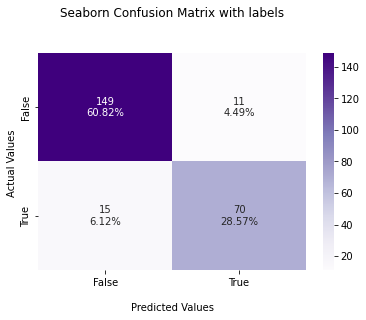

f1 score : 0.8433734939759034
precision score : 0.8641975308641975
recall score : 0.8235294117647058
roc auc score : 0.877389705882353


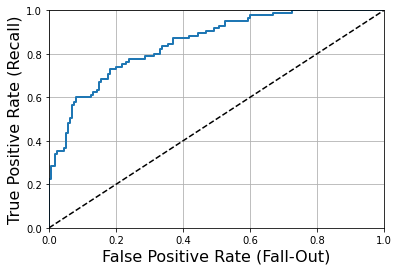

In [17]:
#@title nonlinear SVM test { vertical-output: true }
# nonlinear SVM test

K_fold(X,y,poly_svm_AD,5)
confusion_plt(X_test, y_test, poly_svm_AD)
precision_recall_roc(X_test,y_test,poly_svm_AD)


#1 교차 검증 정확도 : 0.8658,  학습 데이터 크기 : 592,  검증 데이터 크기 : 149
#1 검증 세트 인덱스 : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148]

#2 교차 검증 정확도 : 0.7973,  학습 데이터 크기 : 593,  검증 데이터 크기 : 148
#2 검증 세트 인덱스 : [149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 20

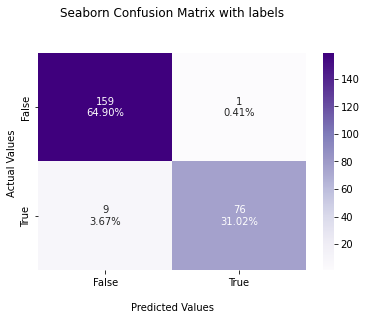

f1 score : 0.9382716049382716
precision score : 0.987012987012987
recall score : 0.8941176470588236
roc auc score : 0.9439338235294118


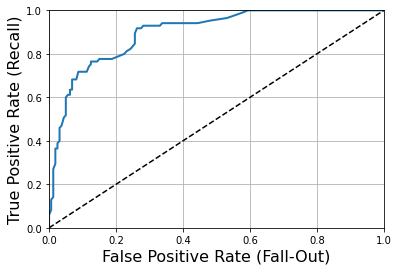

In [18]:
#@title RandomForest test { vertical-output: true }
# RandomForest test

K_fold(X,y,forest_clf_AD,5)
confusion_plt(X_test, y_test, forest_clf_AD)
precision_recall_roc(X_test,y_test,forest_clf_AD)

SGDClassifier(random_state=42) 

f1 score : 0.6065573770491803
precision score : 1.0
recall score : 0.43529411764705883
roc auc score : 0.7176470588235294


LogisticRegression(max_iter=500, random_state=42) 

f1 score : 0.8048780487804879
precision score : 0.8354430379746836
recall score : 0.7764705882352941
roc auc score : 0.8476102941176469


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=1, loss='hinge', max_iter=30000,
                           random_state=42))]) 

f1 score : 0.8235294117647058
precision score : 0.8235294117647058
recall score : 0.8235294117647058
roc auc score : 0.8648897058823529


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=10, loss='hinge', max_iter=400000,
                           random_state=42))]) 

f1 score : 0.8433734939759034
precision score : 0.8641975308641975
recall s

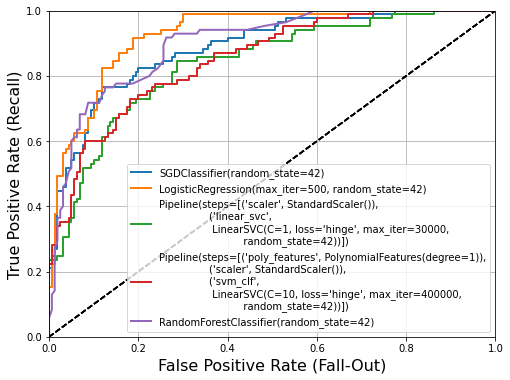

In [28]:
# ROC Curve

plt.figure(figsize=(8, 6))  

model_list = [sgd_clf_AD, log_reg_AD, lin_svm_AD, poly_svm_AD, forest_clf_AD]
for i in model_list:
  print(i,"\n")
  precision_recall_roc(X_test,y_test,i)
  print("\n")

plt.legend(loc="lower right", fontsize=10)